# Problem 1: SOS1 and SOS2 Without SOS (Theory)

> *In many solvers, SOS1 and SOS2 are “native” constraint types.  
> In this problem, you will **derive equivalent MILP formulations** using only **binary variables** and **Big-M** (or indicator constraints), and you will justify correctness.*

Throughout, assume all continuous variables are bounded (you may introduce explicit bounds as part of your formulation).

## Part A: SOS1 from scratch (at most one nonzero)

Let $x_1,\dots,x_n$ be continuous variables with known bounds $0 \le x_i \le U_i \quad \text{for } i=1,\dots,n.$. 

An **SOS1 constraint** on $\{x_1,\dots,x_n\}$ means at most one of $x_1, \dots, x_n$ is nonzero.

### Tasks

1. **Big-M ILP formulation.**  
   Introduce binary variables $z_1,\dots,z_n \in \{0,1\}$ and write a set of linear constraints (using Big-$M$ or the bounds $U_i$) such that the feasible solutions in $(x,z)$-space project exactly onto the SOS1 set in $x$-space.

2. **Exactness proof.**  
   Prove both directions:
   - (Soundness) every feasible ILP solution in $(x, z)$-space satisfies the SOS1 property;
   - (Completeness) every SOS1-feasible $x$ can be extended to some $z$ satisfying your ILP constraints.

## Part B: SOS2 from scratch (at most two adjacent nonzero)

Let $\lambda_1,\dots,\lambda_K$ be continuous variables with
$$
\lambda_k \ge 0 \quad (k=1,\dots,K),
\qquad
\sum_{k=1}^K \lambda_k = 1.
$$

An **SOS2 constraint** on $\{\lambda_1,\dots,\lambda_K\}$ means:
$$
\text{at most two of the }\lambda_k\text{ can be positive, and if two are positive they must be adjacent (}\lambda_j,\lambda_{j+1}\text{).}
$$

### Tasks

1. **Binary segment selection formulation.**  
   Introduce binary variables $z_1,\dots,z_{K-1}\in\{0,1\}$ indicating which *adjacent pair* $(j,j+1)$ is active, and write linear constraints enforcing:
   - exactly one adjacent pair is selected;
   - $\lambda$ can place weight only on the selected pair.

   Your constraints must be linear.

2. **Exactness proof.**  
   Prove your formulation is equivalent to SOS2 under the given simplex constraints $\lambda \ge 0$, $\sum \lambda=1$.

## Deliverables

- A correct MILP formulation for **SOS1**, plus a short correctness proof.
- A correct MILP formulation for **SOS2**, plus a short correctness proof.
- A brief discussion of LP relaxation strength / Big-$M$ dependence (i.e. if $M$ is to large, what happens?).

\newpage 

# Problem 2: Painting a 3D Tic-Tac-Toe Cube (Coding).

> *You are given a tiny 3D tic-tac-toe cube and two paints: red and blue.
> Your job is to color the cube so that as few lines as possible end up all red or all blue.*

We consider a **3 × 3 × 3 cube** of cells:

* 3 positions along the **x**-direction,
* 3 positions along the **y**-direction,
* 3 positions along the **z**-direction,

for a total of **27 cells**.

You must color each cell with exactly one color:

* **13 red** cells,
* **14 blue** cells,

so that all 27 cells are colored (no empty cells).

We say that three cells are on the **same line** if they are:

1. **Axis-aligned** inside the cube

   * Along **x** (row): same (y,z), x varies over ({0,1,2})
   * Along **y** (column): same (x,z), y varies over ({0,1,2})
   * Along **z** (pillar): same (x,y), z varies over ({0,1,2})

   These are the straight 3-in-a-row lines in the directions of the cube’s edges.

2. **Face diagonals** in any 3×3 slice:

   * Diagonals in each **horizontal layer** (constant (z)),
   * Diagonals in each **vertical x–z slice** (constant (y)),
   * Diagonals in each **vertical y–z slice** (constant (x)).

3. **Space diagonals** of the cube:

   * The 4 long diagonals connecting **opposite corners** of the cube.

Altogether, there are exactly **49 distinct lines** of length 3 in the 3×3×3 cube.

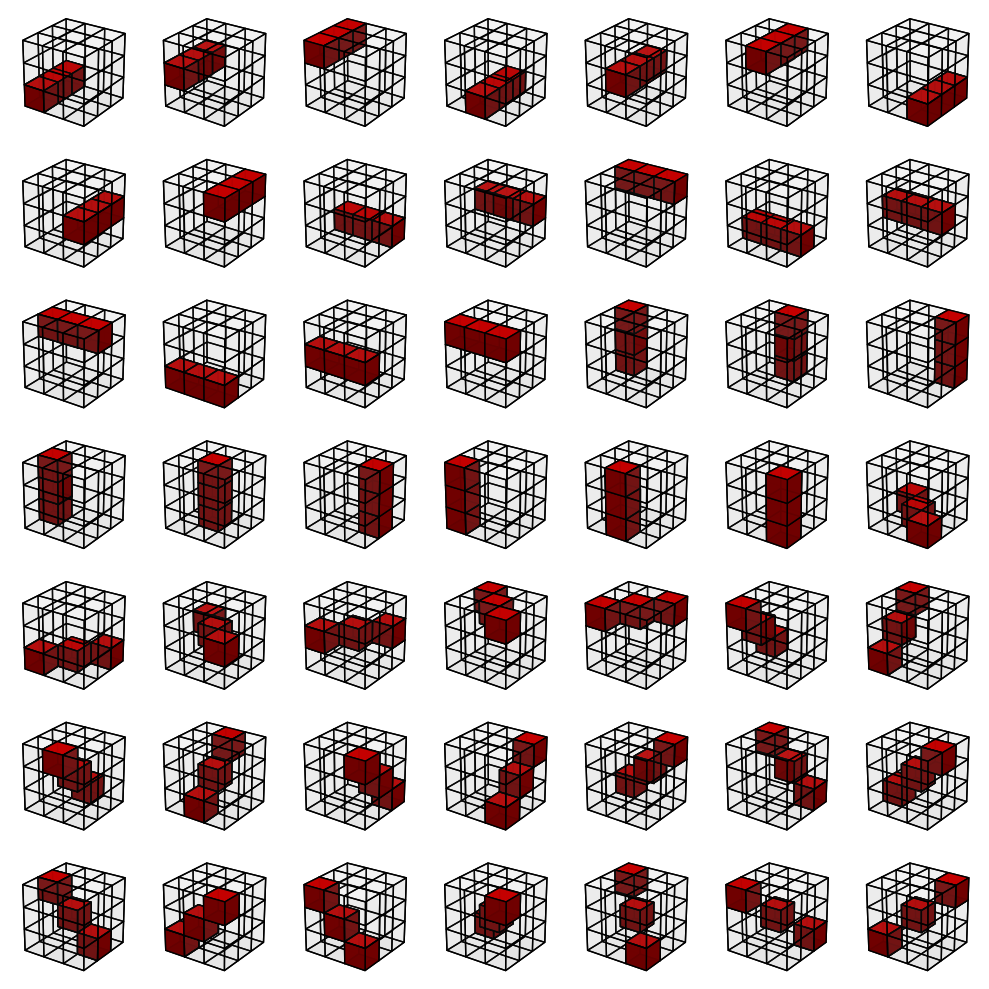

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# ------------------------------------------------------------------
# Enumerate all 49 lines in the 3x3x3 cube
# ------------------------------------------------------------------
def generate_all_lines():
    lines = []
    for y in range(3):
        for z in range(3):
            lines.append([(x, y, z) for x in range(3)])
    for x in range(3):
        for z in range(3):
            lines.append([(x, y, z) for y in range(3)])
    for x in range(3):
        for y in range(3):
            lines.append([(x, y, z) for z in range(3)])
    for z in range(3):
        lines.append([(0, 0, z), (1, 1, z), (2, 2, z)])
        lines.append([(0, 2, z), (1, 1, z), (2, 0, z)])
    for y in range(3):
        lines.append([(0, y, 0), (1, y, 1), (2, y, 2)])
        lines.append([(0, y, 2), (1, y, 1), (2, y, 0)])
    for x in range(3):
        lines.append([(x, 0, 0), (x, 1, 1), (x, 2, 2)])
        lines.append([(x, 0, 2), (x, 1, 1), (x, 2, 0)])
    lines.extend([
        [(0, 0, 0), (1, 1, 1), (2, 2, 2)],
        [(0, 0, 2), (1, 1, 1), (2, 2, 0)],
        [(0, 2, 0), (1, 1, 1), (2, 0, 2)],
        [(0, 2, 2), (1, 1, 1), (2, 0, 0)],
    ])
    assert len(lines) == 49, f"Expected 49 lines, got {len(lines)}"
    return lines

# ------------------------------------------------------------------
# Helper: draw one line
# ------------------------------------------------------------------
def draw_line_voxels_on_axes(ax, line):
    cube = np.ones((3, 3, 3), dtype=bool)
    line_mask = np.zeros_like(cube, dtype=bool)
    for (x, y, z) in line:
        line_mask[x, y, z] = True
    base_mask = cube & ~line_mask
    ax.voxels(
        base_mask,
        facecolors="lightgray",
        edgecolor="k",
        alpha=0.08,      # see-through
    )
    ax.voxels(
        line_mask,
        facecolors="red",
        edgecolor="k",
        alpha=0.95,
    )
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    ax.set_zlim(0, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_box_aspect((1, 1, 1))
    ax.view_init(elev=25, azim=35)
    ax.set_axis_off()

def visualize_all_lines_grid():
    lines = generate_all_lines()
    n = len(lines)         
    rows = cols = 7
    fig = plt.figure(figsize=(10, 10))
    for idx, line in enumerate(lines):
        r = idx // cols
        c = idx % cols
        ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
        draw_line_voxels_on_axes(ax, line)
    plt.tight_layout()
    plt.show()

visualize_all_lines_grid()

A line is called **monochromatic** if **all three cells** in that line are:

* **all red**, or
* **all blue**.

## Optimization goal

You must:

* Assign 13 cells to be **red**, and 14 cells to be **blue**,
* Use each cell exactly once (fully colored cube),

to **minimize the number of monochromatic lines** (3-in-a-row, either color).

In other words:

> Arrange your 13 red and 14 blue cells on the 3×3×3 grid so that as few as possible of the 49 lines end up entirely red or entirely blue.


## Deliverables

Formulate the problem as an integer linear program and write the ILP explicitly. Implement your ILP in gurobi and solve it, and report the minimum number of monochramatic lines (and the code you used), as well as visualize the final coloring.

## Note

In essence, the branch and bound algorithm **proves** that this number is the minimum number of monochromatic lines (i.e. the trace of the B&B algorithm is a completely valid mathematical proof). However, writing a human-readable proof for this problem turns out to be extremely hard. Try it for youself (300pts bonus for a full formal proof!). If you were writing a paper, you *can* use the trace of the B&B algorithm as a computer-assisted proof. 

\newpage 

# Problem 3: McCormick linearization (Gradescope)

Let's start with a toy problem. 

Consider $D$ departments and $C$ candidate cities $D > C$. Each department must be located in **exactly one** city.

- Let `x[d,c] ∈ {0,1}` = 1 if department d is located in city c.
- Each pair of departments $i,j$ has a communication volume `h[i,j]` (calls/day).
- Each pair of cities $c_1,c_2$ has a communication cost per unit `d[c₁,c₂]`.
- If departments $i$ and $j$ are placed in cities $c_1$ and $c_2$, their communication cost is:
  $h[i,j] \cdot d[c_1,c_2]$.
- Additionally, if a department $i$ is relocated to city $c$, then we get a benefit of $b[i, c]$ dollars. 
- We want to minimize the total sum of all communication costs across all pairs of departments. 

### Naive Initial Model

The constraint on each department being in exactly one city is easy; for all departments $d$:

$$
\sum_{c}x[d, c] = 1
$$

The total communication cost, however, is:

$$
\sum_{i}\sum_{c}b[i, c]x_{i, c} + \sum_{i<j}\sum_{c_1}\sum_{c_2} h_{ij} d_{c_1 c_2} x_{i,c_1} x_{j,c_2}.
$$

This is **quadratic** in the variables (x's), so this not an LP or an ILP. This exercise will guide you to apply McCormick linearization to replace the quadratic binary terms with linear ones. 

### Linearization Idea

Introduce variables `z[i,j,c1,c2]` intended to represent:
- $z[i,j,c1,c2] = x[i,c1] \cdot  x[j,c2]$

Consider the three McCormick linearization constraints:
- `z[i, j, c_1, c_2] <= x[i,c1]`
- `z[i, j, c_1, c_2] <= x[j,c2]`
- `z[i, j, c_1, c_2] >= x[i,c1] + x[j,c2] − 1`

We look at a single pair of departments $i,j$ and cities $c_1,c_2$.
Let:

* $x_i = x[i,c_1] \in \{0,1\}$
* $x_j = x[j,c_2] \in \{0,1\}$
* $z = z[i,j,c_1,c_2]$

Constraints:

* $z \le x_i$
* $z \le x_j$
* $z \ge x_i + x_j - 1$

Truth table (Fill it in!):

| $x[i,c_1]$ | $x[j,c_2]$ | $z \le x[i,c_1]$ | $z \le x[j,c_2]$ | $z \ge x[i,c_1] + x[j,c_2] - 1$ | Allowed $z$ | $x[i,c_1]\cdot x[j,c_2]$ |
| :--------: | :--------: | :--------------: | :--------------: | :-----------------------------: | :---------: | :----------------------: |
|      0     |      0     |     $z \le ??$    |     $z \le ??$    |        $z \ge ??$       |   $z = ??$   |             ??            |
|      0     |      1     |     $z \le ??$    |     $z \le ??$    |        $z \ge ??$        |   $z = ??$   |             ??            |
|      1     |      0     |     $z \le ??$    |     $z \le ??$    |        $z \ge ??$        |   $z = ??$   |             ??            |
|      1     |      1     |     $z \le ??$    |     $z \le ??$    |        $z \ge ??$        |   $z = ??$   |             ??            |

**Conclusion:**

For binary $x[i,c_1]$ and $x[j,c_2]$, the McCormick constraints forces

$$
z[i,j,c_1,c_2] = x[i,c_1]\cdot x[j,c_2]
$$

So we can replace the quadratic term $x[i,c_1]x[j,c_2]$ in the objective with a new variable $z[i,j,c_1,c_2]$ and a set of linear constraints.

Then the objective becomes linear in z:

$$
\min \sum_{i}\sum_{c}b[i, c]x_{i, c} + \sum_{i<j}\sum_{c_1}\sum_{c_2} h_{ij} d_{c_1 c_2} z_{ijc_1c_2}
$$

Now we will use this idea to solve a new problem. 

### Team assignment with collaboration effects and capacity

A company must assign employees to project teams.

* There are $N$ employees and $T$ teams, with $N > T$.
* Each employee must be assigned to **exactly one** team.
* Each team can have **at most** (K) employees.

#### Decision variables

* $x[i,t] \in \{0,1\}$: $x[i,t]=1$ iff employee $i$ is assigned to team $t$.

#### Data

* $c[i,t]$: base cost of assigning employee $i$ to team $t$.
* $s[i,j]$: collaboration intensity between employees $i$ and $j$ (symmetric, and $s[i,i]=0$).
* $w[t]$: productivity multiplier for team $t$.
* $K$: maximum team size.

If employees $i$ and $j$ are assigned to the **same team** $t$, they generate a productivity gain:

$$
s[i,j]\cdot w[t].
$$

#### Given nonlinear model

Assignment constraints:

$$
\sum_{t} x[i,t] = 1 \qquad \forall i
$$

Capacity constraints:

$$
\sum_i x[i,t] \le K \qquad \forall t
$$

Objective:

$$
\min \sum_{i}\sum_{t} c[i,t],x[i,t] -  \sum_{i<j}\sum_{t} s[i,j],w[t];x[i,t],x[j,t].
$$

This objective is **not linear**.

### What you must submit

Create a file named:

**`hw3_p3_team.py`**

and implement:

```python
def build_team_ilp(c, s, w, K):
    """
    Inputs:
      c: numpy array shape (N,T)
      s: numpy array shape (N,N) symmetric with zeros on diagonal
      w: numpy array shape (T,)
      K: int

    Return:
      (model, x)

    where:
      model is a gurobipy.Model that is a PURE MILP (no quadratic objective/constraints),
      x is a dict keyed by (i,t) -> gurobipy.Var for the assignment variables x[i,t].
    """
    raise NotImplementedError 
```

Your model must:

* enforce the two constraint sets (exactly-one assignment and capacity),
* use only **linear** expressions (no quadratic objective, no quadratic constraints),
* optimize to the correct minimum objective value.

\newpage

# Problem 4: Your Own Branch-and-Bound Knapsack Solver (Gradescope)

> Before trusting a MIP solver’s magic, you’ll build a **tiny** one yourself for knapsack.

You’ll implement a recursive **Branch-and-Bound (B&B)** algorithm for a small 0–1 knapsack problem. You may use **Gurobi only to solve LP relaxations** at each node (i.e., relax $x\in\{0,1\}$ to $0\leq x \leq 1$). The branching logic and pruning must be yours.

## The 0/1 Knapsack Model

You are choosing a subset of items with value $v_i$ and weight $w_i$ to fit into a knapsack of capacity $C$:

* Decision variables:
  
  $$
  x_i \in \{0,1\} \quad \text{(1 if item i is chosen)}
  $$
  
* Objective:

  $$
  \max \sum_i v_i x_i
  $$
  
* Capacity constraint:
  
  $$
  \sum_i w_i x_i \le C
  $$


## B&B overview (what your code should do)

A B&B **node** consists of some fixed variable assignments like:

$$
\{x_1=1, x_3=0\}
$$

At each node:

1. Build & solve the **LP relaxation** with those variable fixings.
2. If infeasible: prune.
3. If LP bound $\le$ best incumbent value: prune.
4. If LP solution is integral: update incumbent.
5. Otherwise pick a fractional variable $x_k$ and branch:
   * Left child: add fixing $x_k=0$
   * Right child: add fixing $x_k=1$

You should print a small trace of the search (node fixes, LP bound, whether pruned, etc.). (Printing is not graded, but helpful.)


## Deliverable

Submit a single file:

**`hw3_p4_bnb.py`**

You must fill in the TODOs in the provided skeleton. Your `solve()` should return:

* best objective value,
* best 0/1 solution (as a dict `{i:0/1}`),
* number of nodes explored.

## Starter skeleton (copy into `hw3_p4_bnb.py`)

```python
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Optional, Tuple, List
import numpy as np
import gurobipy as gp
from gurobipy import GRB


@dataclass
class Node:
    """
    A node in the Branch-and-Bound tree.

    fixes:    variable index -> 0/1 (fixed assignments inherited from the B&B tree)
    bound:    LP relaxation objective value (upper bound for maximization)
    solution: LP relaxation solution (possibly fractional): index -> value
    """
    fixes: Dict[int, int]
    bound: Optional[float] = None
    solution: Optional[Dict[int, float]] = None


class KnapsackBranchAndBound:
    def __init__(self, values: List[float], weights: List[float], capacity: float):
        assert len(values) == len(weights), "values and weights must have same length"
        self.values = values
        self.weights = weights
        self.capacity = capacity
        self.n = len(values)

        # incumbent
        self.best_obj: float = float("-inf")
        self.best_sol: Optional[Dict[int, int]] = None

        # bookkeeping
        self.node_count: int = 0

    # -------------------------------
    # Solve LP relaxation at a node
    # -------------------------------
    def solve_relax(self, node: Node) -> int:
        """
        Solve the LP relaxation at the given node, updating node.bound and node.solution.

        Requirements:
        - Variables must be continuous with bounds [0,1].
        - Add the capacity constraint.
        - Apply all fixings in node.fixes (force x[i] == 0 or 1).
        - Objective: maximize sum_i v[i] * x[i].

        Returns: Gurobi status code.
        """
        m = gp.Model("node_relax")
        m.Params.OutputFlag = 0

        x = m.addVars(self.n, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")

        # TODO (1): Add capacity constraint: sum_i w[i] * x[i] <= C

        # TODO (2): Apply fixings from node.fixes (e.g., constraints x[i] == val)

        # TODO (3): Set objective to maximize total value

        m.optimize()
        status = m.Status

        # TODO (4): If optimal, set:
        #   node.bound = objective value (float)
        #   node.solution = {i: x[i].X for i in range(n)}
        # Else set node.bound and node.solution to None

        return status

    # -------------------------------
    # Choose branching variable
    # -------------------------------
    def choose_branch_var(self, node: Node) -> Optional[int]:
        """
        Return an index of a fractional (non-integer) variable to branch on.
        If more than one variable is fractional, break ties on the first fractional variable 
            you find in order range(self.n).
        Return None if all unfixed variables are integral.
        """
        if node.solution is None:
            return None

        # TODO (5): Find an i not in node.fixes with node.solution[i] fractional.
        # TODO: branch on the first fractional variable you find to break ties.
        return None

    # -------------------------------
    # Recursive Branch-and-Bound
    # -------------------------------
    def branch_and_bound(self, node: Node) -> None:
        """
        Recursive B&B procedure.

        Expected logic:
        - Solve LP relaxation at node
        - Prune if infeasible/non-optimal
        - Prune if bound <= incumbent
        - If solution integral: update incumbent
        - Else branch on fractional variable:
            left: fix x[k]=0
            right: fix x[k]=1
        """
        self.node_count += 1

        status = self.solve_relax(node)
        print(
            f"Node {self.node_count}, fixes={node.fixes}, status={status}, "
            f"bound={node.bound}, incumbent={self.best_obj}"
        )

        # TODO (6): Prune if LP is infeasible or not optimal (no valid bound) [Just return]

        # TODO (7): Prune if node.bound is not better than incumbent self.best_obj [Just return]

        # TODO (8): Check if node.solution is integral (using choose_branch_var or your own check)
        # If integral:
        #   update self.best_obj and self.best_sol (update incumbent if needed)
        #   return

        # TODO (9): Otherwise, pick branching variable k and create children:
        #   left child fixes = node.fixes plus {k: 0}
        #   right child fixes = node.fixes plus {k: 1}
        # Then recurse on each child (order is up to you).

        return

    def solve(self) -> Tuple[float, Dict[int, int], int]:
        """
        Run Branch-and-Bound from the root node.
        Returns (best_obj, best_sol_dict, node_count).
        """
        self.best_obj = float("-inf")
        self.best_sol = None
        self.node_count = 0

        root = Node(fixes={})
        self.branch_and_bound(root)

        return self.best_obj, (self.best_sol or {}), self.node_count
```

Sample usage:
```python
values = [20, 18, 14, 10, 8, 7, 6, 5]
weights = [6, 5, 4, 3, 4, 2, 3, 2]
capacity = 15

print("=== Custom Branch-and-Bound trace ===")
bnb = KnapsackBranchAndBound(values, weights, capacity)
best_obj, best_sol, nodes = bnb.solve()
print("\nBest objective:", best_obj)
print("Best solution:", best_sol)
print("Nodes visited:", nodes)
```

\newpage

# Problem 5: A 2-Approximation for 0–1 Knapsack (Theory + Gradescope Coding)

You are given a 0–1 knapsack instance with:

* items $i=0,\dots,n-1$
* values $v_i \ge 0$, weights $w_i > 0$
* capacity $C$

Decision variables $x_i \in \{0,1\}$ indicate whether we take item $i$.

$$
\max \sum_i v_i x_i \quad\text{s.t.}\quad \sum_i w_i x_i \le C,\quad x_i\in \{0,1\}.
$$

## Part A: Theory

We will study two simple heuristics and then combine them to get a **2-approximation**.

### Algorithm 1 (Greedy-by-density)

Sort items by "bang-per-buck" (density) $ \rho_i = v_i / w_i $ from largest to smallest. Scan in that order and add an item if it fits within your (remaining) budget.

Call the resulting set $G$, with value $V(G)$.

### Algorithm 2 (Best single item)

Pick the single feasible item with the largest value:

$$
S = \text{arg}\max\{v_i : w_i \leq C\},
$$

with value $V(S)$ (or $0$ if no item fits).

### Combined Algorithm (what you will implement)

Return the better of the two:

$$
A = \max\{V(G),V(S)\}.
$$

### A1. Show each strategy alone can be arbitrarily bad

1. (**Greedy-by-density can be arbitrarily bad**)
   Construct an instance where greedy-by-density returns value close to $1$, but the optimal integer solution value is much larger.

2. (**Best single item can be arbitrarily bad**)
   Construct an instance where the best single item has value $1$, but the optimal solution can be much larger.

### A2. Prove the combined algorithm is a 2-approximation

Let OPT be the optimal integer value.

You will prove:

$$
\max\{V(G), V(S)\} \ge \frac{1}{2},\text{OPT}.
$$

**Step 1 (Fractional knapsack upper bound):**

Consider the **fractional knapsack** solution obtained by sorting by density and filling greedily (strategy 1), but allowing the *last* item to be taken fractionally. Let its value be $F$.
Explain why:

$$
F \ge \text{OPT}.
$$

Hint: Prove that this fractional solution is the optimal solution to the fractional relaxation of knapsack (i.e. relaxing $0\leq x_i\leq 1$).  

**Step 2 (Structure of the fractional solution):**
In the fractional greedy solution, all items before some index $k$ are taken fully, and item $k$ is possibly fractional. Write:

$$
F = V(\text{items before }k) + \alpha v_k
$$
for some (\alpha \in [0,1]).

Let $V(G)$ denote the value of the **0–1 greedy** solution (which takes exactly the "items before $k$" and then stops when the next item doesn’t fit).

Show:

$$
V(G) = V(\text{items before }k).
$$

**Step 3 (The key inequality):**
Use Step 2 to argue:

$$
F \le V(G) + v_k.
$$

**Step 4 (Relate $v_k$ to best single):**
Argue that the best single feasible item satisfies:

$$
V(S) \ge v_k.
$$

(Hint: why is item $k$ feasible by itself?)

**Step 5 (Finish):**
Combine the above steps to show:

$$
\text{OPT} \le F \le V(G) + V(S) \le 2\max\{V(G),V(S)\}.
$$

Conclude:

$$
\max\{V(G),V(S)\} \ge \frac{1}{2}\text{OPT}.
$$

---

## Part B: Coding (Gradescope)

Implement the combined 2-approximation algorithm.

### Deliverable

Submit one file:

**`hw3_p5_knapsack_approx.py`**

with the function:

```python
def knapsack_2approx(values, weights, capacity):
    """
    values: list[float] or list[int]
    weights: list[float] or list[int]
    capacity: float or int

    Return a solution in this format:
      - dict {i: 0/1} indicating if item i is chosen or not for all i=0...n-1.

    Must be feasible: sum(weights[i] for chosen i) <= capacity and a 2-approximation.
    """
```

### Requirements

Your function must:

1. Compute the greedy-by-density solution $G$.
2. Compute the best-single-item solution $S$.
3. Return whichever has larger total value (break ties however you want).
4. Run fast (you will be tested on many random instances).

**Important:** You should implement the greedy by sorting by density $v_i / w_i$. (Ties can be broken arbitrarily; the autograder checks the approximation guarantee, not your exact choices.)